In [1]:
!wget http://giagu.web.cern.ch/giagu/CERN/ct_lesion_seg.zip

import zipfile

with zipfile.ZipFile('ct_lesion_seg.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

--2022-09-07 09:52:07--  http://giagu.web.cern.ch/giagu/CERN/ct_lesion_seg.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 884253723 (843M) [application/zip]
Saving to: ‘ct_lesion_seg.zip’

ct_lesion_seg.zip   100%[===================>] 843.29M   635KB/s    in 28m 38s 

2022-09-07 10:20:47 (503 KB/s) - ‘ct_lesion_seg.zip’ saved [884253723/884253723]



In [2]:
%pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from posix import listdir
from posixpath import join
import os
from PIL import Image
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow import keras
from typing import Callable, Union
from keras import backend_config
from keras.engine import keras_tensor
from tensorflow.keras.utils import normalize
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
import cv2
import gc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from natsort import natsorted, ns #natsorted ordina i numeri nelle stringhe 
#non in ASCII (0,1,10,100,11,2...) ma numericamente (0,1,2,10,100...)
print(tf.__version__)
print(keras.__version__)
import random
random.seed(12345)

2.8.2
2.8.0


In [5]:
#creiamo la lista 'mask' dove ordiniamo i percorsi alle maschere 
input_dir = '/content/ct_lesion_seg/mask'

A_path = sorted([
      os.path.join(input_dir, fname)
      for fname in os.listdir(input_dir)
    ])

cases_path =A_path[1:] #togliamo il percorso che non ci interessa '.DS_store'

mask=[]
for i in range(len(cases_path)):
  mask.append ( [
      os.path.join(cases_path[i], fname)
      for fname in os.listdir(cases_path[i])
    ])
  mask[i]=natsorted(mask[i])
mask=natsorted(mask)
#print(mask)


# creiamo la lista 'image' dove ordiniamo i percorsi delle immagini
input_dir1 = '/content/ct_lesion_seg/image'
B_path = sorted([
      os.path.join(input_dir1, fname)
      for fname in os.listdir(input_dir1)
    ])

cases_path1 =B_path[1:]  #togliamo il percorso che non ci interessa '.DS_store'

image=[]
for i in range(len(cases_path1)):
  image.append ( [
      os.path.join(cases_path1[i], fname)
      for fname in os.listdir(cases_path1[i])  
    ])
  image[i]=natsorted(image[i])
image=natsorted(image)
#print(image)
#creiamo la lista 'mask_and_image' dove mettiamo le maschere e le relative immagini catalogate per paziente
mask_and_image=mask

for i in range(len(cases_path)):
    if(i<10):z=0
    elif(i>99): z=2
    else: z=1
    for j in range(len(mask[i])):
        a=int(os.path.basename(os.path.normpath(mask[i][j][30+z:-4]))) #leggo i numeri delle maschere riferite al paziente i
        mask_and_image[i].append(image[i][a])
#mask_and_image[paziente][maschere e immagini relative] maschere[i][0:4], immagini [i][5:9]
#[0][0] paziente 0 maschera 0 che sarà la 23 in questo caso
#[0][5] paziente 0 immagine "0" che sarà la 23
#alla maschera[i][a] corrisponde l'immagine[i][a+5]

test_512=[]
for i in range(5):
  rnd_j = random.randint(0, 149-i)
  print(rnd_j)
  test_512.append(mask_and_image[rnd_j][:])  
  mask_and_image.pop(rnd_j)
#ho messo da parte immagini e maschere relative a 5 pazienti 
#per un totale di 25 immagini e 25 maschere 512x512 pixels
#in modo random

106
2
76
94
49


In [6]:
#Andiamo a creare le liste 'images' e 'masks' dove andremmo a mettere 
#le immagini 128x128 pixels che creiamo con patchify

images = []
masks= []

patch_size = 128


for i in range(len(mask_and_image[:])):
  for j in range(5):
   
    mask = cv2.imread(mask_and_image[i][j],0)
    patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)   
      
    for k in range(patches_mask.shape[0]):
      for l in range(patches_mask.shape[1]):
         single_patch_mask = patches_mask[k,l,:,:]
         masks.append(single_patch_mask)

    
      
    img = cv2.imread(mask_and_image[i][j+5],0)

    patches_img = patchify(img, (patch_size, patch_size), step=patch_size)

    for y in range(patches_img.shape[0]):
      for z in range(patches_img.shape[1]):
        single_patch_img = patches_img[y,z,:,:]

        single_patch_img = normalize(np.array(single_patch_img), axis=1)
        images.append(single_patch_img)

  
images = np.array(images)
masks =  np.array(masks)

images = np.expand_dims(images, axis=3)
masks = np.expand_dims(masks, axis=3)


print(images.shape)
print(masks.shape)

(11600, 128, 128, 1)
(11600, 128, 128, 1)


In [8]:
#andiamo a creare le liste 'mask_nl' e 'image_nl' dove andiamo a mettere le maschere
# e relative immagini controllando le label
#in partciolare andiamo a mettere tutte le label relative a glass opacity e consolidation
#(label 2,3) e possiamo dopo aggiungere anche le label relative solo al polmone e al fondo
#([0],[0,1]) in base a delle percentuali scelte da noi per creare il dataset

labels=[0,1,2,3]

mask_nl = []
image_nl = []
mask_1l=[]
image_1l=[]
mask_2l=[]
image_2l=[]


for i in range(len(masks)):
    
  if np.array_equal(labels[:-2],np.unique(masks[i])): #andiamo a prendere le immagini con 2 label (0,1) 
    #image_2l.append(images[i])
    #mask_2l.append(masks[i])
    rnd_j=random.randint(0,99)
    if(rnd_j<49):  #metto il 50% delle maschere con label [0,1]
      mask_2l.append(masks[i])
      image_2l.append(images[i])

  elif np.array_equal(labels[:-3],np.unique(masks[i])): #andiamo a prendere le immagini con una label (0)
    #image_1l.append(images[i])
    #mask_1l.append(masks[i])
    rnd_k=random.randint(0,99)
    if(rnd_k<2): #metto il 3% delle maschere con label [0]
      mask_1l.append(masks[i])
      image_1l.append(images[i])


  elif(2 in np.unique(masks[i]) or 3 in np.unique(masks[i])):
    mask_nl.append(masks[i]) #le immagini con combinazioni di label diverse da quelle sopra, tipo (0,1,3),(0,2,3),(0,2),(0,3),(0,1,2,3)
    image_nl.append(images[i])


image_2l=np.array(image_2l)
print(image_2l.shape)
mask_2l=np.array(mask_2l)
print(mask_2l.shape)
print(np.unique(mask_2l))

image_1l=np.array(image_1l)
print(image_1l.shape)
mask_1l=np.array(mask_1l)
print(mask_1l.shape)
print(np.unique(mask_1l))

image_nl = np.array(image_nl)
mask_nl = np.array(mask_nl)
print(mask_nl.shape)
print(image_nl.shape)
print(np.unique(mask_nl))

(1894, 128, 128, 1)
(1894, 128, 128, 1)
[0 1]
(110, 128, 128, 1)
(110, 128, 128, 1)
[0]
(1999, 128, 128, 1)
(1999, 128, 128, 1)
[0 1 2 3]


In [9]:
# prendiamo immegini e maschere per allenare il modello 
#passaggio intermedio che possiamo anche togliere


random_img=np.concatenate((image_nl,image_1l,image_2l),axis=0)
random_msk=np.concatenate((mask_nl,mask_1l,mask_2l),axis=0)
#random_img=image_nl
#random_msk=mask_nl
random_img = np.array(random_img)
random_msk = np.array(random_msk)

print(random_img.shape)
print(random_msk.shape)

(4003, 128, 128, 1)
(4003, 128, 128, 1)


In [10]:
#dividiamo il dataset in train(60%), validation(20%) e test(20%)
from sklearn.model_selection import train_test_split
X_train, X, y_train, y = train_test_split(random_img, random_msk, test_size = 0.20,random_state=12345,shuffle=True) #dividiamo il dataset in train e test
X_test, X_vali, y_test, y_vali = train_test_split(X, y, test_size = 0.50, random_state = 12345,shuffle=True) #dividiamo il dataset in train e test

print(X_train.shape[0])

3202


In [11]:
import albumentations as A

trasformation = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.ElasticTransform(p=0.5, alpha=150, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.5),
])

augmented = []
image_aug = []
mask_aug = []
counter = 0

for i in range(10):
  for j in range(X_train.shape[0]):
    if(2 in np.unique(y_train[j]) or 3 in np.unique(y_train[j])): 
        augmented.append(trasformation(image=X_train[j][:,:,:], mask=y_train[j][:,:,:]))
        image_aug.append(augmented[counter]['image'])
        mask_aug.append(augmented[counter]['mask'])
        counter += 1
    

image_aug = np.array(image_aug)
mask_aug = np.array(mask_aug)

print(image_aug.shape)
print(mask_aug.shape)

(15870, 128, 128, 1)
(15870, 128, 128, 1)


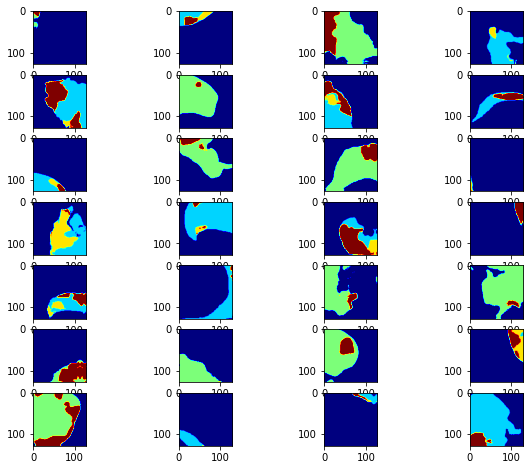

In [12]:
# verifichiamo che le trasformazioni 
figure = plt.figure(figsize=(10, 8))
cols, rows = 4,7
for i in range(1, cols * rows + 1):
  figure.add_subplot(rows, cols, i)
  plt.imshow(mask_aug[i][:,:,0], cmap='jet')

In [19]:
del random_img,random_msk,images,masks,augmented

gc.collect()

2349

In [20]:
X_train = np.concatenate((X_train,image_aug), axis = 0)
y_train = np.concatenate((y_train,mask_aug), axis = 0)

print(X_train.shape)

(19072, 128, 128, 1)


In [21]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#definiamo il modello
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
def Weighted_BCEnDice_loss(y_true, y_pred):
    
    # convert the tensor to one-hot for multi-class segmentation
    y_true = K.squeeze(y_true, 3)
    y_true = tf.cast(y_true, "int32")
    y_true = tf.one_hot(y_true, 4, axis=-1)
       
   
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss =  weighted_dice_loss(y_true, y_pred, weight) + weighted_bce_loss(y_true, y_pred, weight) 
    return loss
    
def weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    #logit_y_pred = y_pred
    
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * (m1**2)) + K.sum(w * (m2**2)) + smooth) # Uptill here is Dice Loss with squared
    loss = 1. - K.sum(score)  #Soft Dice Loss
    return loss

In [22]:
def FocalLoss(y_true, y_pred):   
    
    alpha = 0.8
    gamma = 2

    # convert the tensor to one-hot for multi-class segmentation
    y_true = K.squeeze(y_true, 3)
    y_true = tf.cast(y_true, "int32")
    y_true = tf.one_hot(y_true, 4, axis=-1)
    
    # cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    
    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [23]:
# IoU metrica

def mean_iou(y_true, y_pred, smooth=1):
    
    y_true = K.squeeze(y_true, 3)
    y_true = tf.cast(y_true, "int32")
    y_true = tf.one_hot(y_true, 4, axis=-1)
        
    
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(y_pred > 0.5, "int32")
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=[1,0])
    
    return iou

In [24]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=4, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()

In [ ]:
from keras.callbacks import LearningRateScheduler
def decay_schedule(epoch, lr):
    # decay by 0.3 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % 3 == 0) and (epoch != 0):
      lr=lr=lr*0.5
    return lr
#provare lr=lr*k/np.sqrt(epoch) con k costante da scegliere tipo 1,0.5,0.4
callback = LearningRateScheduler(decay_schedule)

In [25]:
class LossLearningRateScheduler(tf.keras.callbacks.History):
    """
    base_lr: the starting learning rate
    lookback_epochs: the number of epochs in the past to compare with the loss function at the current epoch to determine if progress is being made.
    decay_threshold / decay_multiple: if loss function has not improved by a factor of decay_threshold * lookback_epochs, then decay_multiple will be applied to the learning rate.
    spike_epochs: list of the epoch numbers where you want to spike the learning rate.
    spike_multiple: the multiple applied to the current learning rate for a spike.
    """

    def __init__(self, base_lr, lookback_epochs, spike_epochs = None, spike_multiple = 10, decay_threshold = 0.002, decay_multiple = 0.7, loss_type = 'val_loss'):


        super(LossLearningRateScheduler, self).__init__()
        self.base_lr = base_lr
        self.lookback_epochs = lookback_epochs
        self.spike_epochs = spike_epochs
        self.spike_multiple = spike_multiple
        self.decay_threshold = decay_threshold
        self.decay_multiple = decay_multiple
        self.loss_type = loss_type


    def on_epoch_begin(self, epoch, logs=None):


        if len(self.epoch) > self.lookback_epochs:


            current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)


            target_loss = self.history[self.loss_type] 


            loss_diff =  target_loss[-int(self.lookback_epochs)] - target_loss[-1]


            if loss_diff <= np.abs(target_loss[-1]) * (self.decay_threshold * self.lookback_epochs):


                print(' '.join(('Changing learning rate from', str(current_lr), 'to', str(current_lr * self.decay_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.decay_multiple)
                current_lr = current_lr * self.decay_multiple


            else:


                print(' '.join(('Learning rate:', str(current_lr))))


            if self.spike_epochs is not None and len(self.epoch) in self.spike_epochs:
                print(' '.join(('Spiking learning rate from', str(current_lr), 'to', str(current_lr * self.spike_multiple))))
                tf.keras.backend.set_value(self.model.optimizer.lr, current_lr * self.spike_multiple)


        else:


            print(' '.join(('Setting learning rate to', str(self.base_lr))))
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

        return tf.keras.backend.get_value(self.model.optimizer.lr)



callback_lr = LossLearningRateScheduler(base_lr=0.001, lookback_epochs=3)

In [26]:
#tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=[FocalLoss],
             metrics=[mean_iou])
model.summary()
print(model.input_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [27]:
device_name = tf.test.gpu_device_name()     #chiamo la GPU
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [28]:
with tf.device(device_name):                 #addestriamo l'algoritmo
     history1 = model.fit(X_train,y_train, 
                   batch_size = 8, 
                    verbose='auto', 
                    epochs=50, 
                    validation_data=(X_vali, y_vali),
                    callbacks=callback_lr,
                    shuffle=False)

Setting learning rate to 0.001
Epoch 1/50
2384/2384 [==============================] - 74s 25ms/step - loss: 0.0379 - mean_iou: 0.5497 - val_loss: 0.0198 - val_mean_iou: 0.7441
Setting learning rate to 0.001
Epoch 2/50
2384/2384 [==============================] - 60s 25ms/step - loss: 0.0236 - mean_iou: 0.5953 - val_loss: 0.0118 - val_mean_iou: 0.7590
Setting learning rate to 0.001
Epoch 3/50
2384/2384 [==============================] - 59s 25ms/step - loss: 0.0200 - mean_iou: 0.6088 - val_loss: 0.0125 - val_mean_iou: 0.7678
Setting learning rate to 0.001
Epoch 4/50
2384/2384 [==============================] - 59s 25ms/step - loss: 0.0191 - mean_iou: 0.6163 - val_loss: 0.0125 - val_mean_iou: 0.7576
Changing learning rate from 0.001 to 0.0007000000332482159
Epoch 5/50
2384/2384 [==============================] - 60s 25ms/step - loss: 0.0169 - mean_iou: 0.6300 - val_loss: 0.0112 - val_mean_iou: 0.7686
Learning rate: 0.00070000003
Epoch 6/50
2384/2384 [==============================] - 60

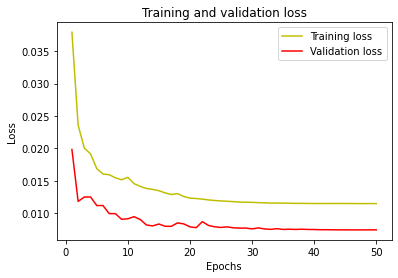

In [29]:
#plottiamo la loss della validation e del training
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:
#Andiamo a predire il test
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [31]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#Valutiamo la IoU per ogni classe sulla parte di immagini con tutte le label di test
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.7269936
[[4.768167e+06 3.368400e+04 1.991000e+03 1.329000e+03]
 [1.937500e+04 1.481390e+06 2.866600e+04 2.948000e+03]
 [1.303000e+03 5.735200e+04 9.204800e+04 1.188100e+04]
 [5.257000e+03 2.072000e+03 7.730000e+03 3.840700e+04]]
IoU for class1 is:  0.98697215
IoU for class2 is:  0.9113515
IoU for class3 is:  0.45801634
IoU for class4 is:  0.5516345


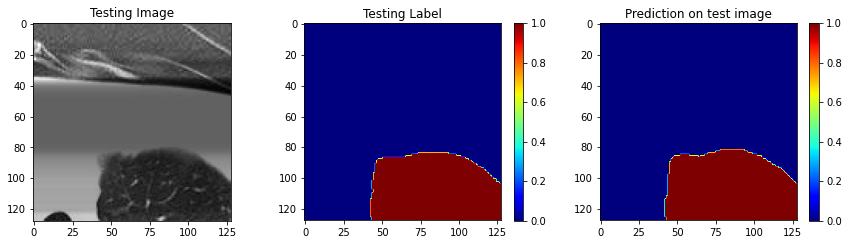

In [32]:
import random
test_img_number = random.randint(0, len(X_test))          #andiamo a vedere le immagini, le mask e le predizioni
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(15, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.colorbar()
plt.show()

In [33]:
# prendiamo un'immagine casuale intera che dividiamo in immagini 128x128 su cui faremo le predizioni, il risultato verrà ricostruito nell'immagine intera

import random

rnd_i = random.randint(0, 4)
rnd_j = random.randint(0, 4)
print(test_512)
print(rnd_i,rnd_j)
maschera = cv2.imread(test_512[rnd_i][rnd_j],0)
immagine = cv2.imread(test_512[rnd_i][rnd_j+5],0)

imm_patch = []

patches = patchify(immagine, (128, 128), step=128)
print(patches.shape)

for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        #print(i,j)
            
        single_patch = patches[i,j,:,:]
        
       
        single_patch_norm = normalize(np.array(single_patch),axis=1)
       
        imm_patch.append(single_patch_norm)
       
#imm_patch = np.array(imm_patch)
imm_patch = np.expand_dims(imm_patch, axis=3)

print(imm_patch.shape)

[['/content/ct_lesion_seg/mask/106/25.png', '/content/ct_lesion_seg/mask/106/51.png', '/content/ct_lesion_seg/mask/106/77.png', '/content/ct_lesion_seg/mask/106/103.png', '/content/ct_lesion_seg/mask/106/129.png', '/content/ct_lesion_seg/image/106/25.jpg', '/content/ct_lesion_seg/image/106/51.jpg', '/content/ct_lesion_seg/image/106/77.jpg', '/content/ct_lesion_seg/image/106/103.jpg', '/content/ct_lesion_seg/image/106/129.jpg'], ['/content/ct_lesion_seg/mask/2/23.png', '/content/ct_lesion_seg/mask/2/46.png', '/content/ct_lesion_seg/mask/2/69.png', '/content/ct_lesion_seg/mask/2/92.png', '/content/ct_lesion_seg/mask/2/115.png', '/content/ct_lesion_seg/image/2/23.jpg', '/content/ct_lesion_seg/image/2/46.jpg', '/content/ct_lesion_seg/image/2/69.jpg', '/content/ct_lesion_seg/image/2/92.jpg', '/content/ct_lesion_seg/image/2/115.jpg'], ['/content/ct_lesion_seg/mask/77/24.png', '/content/ct_lesion_seg/mask/77/48.png', '/content/ct_lesion_seg/mask/77/72.png', '/content/ct_lesion_seg/mask/77/96.

(16, 128, 128)


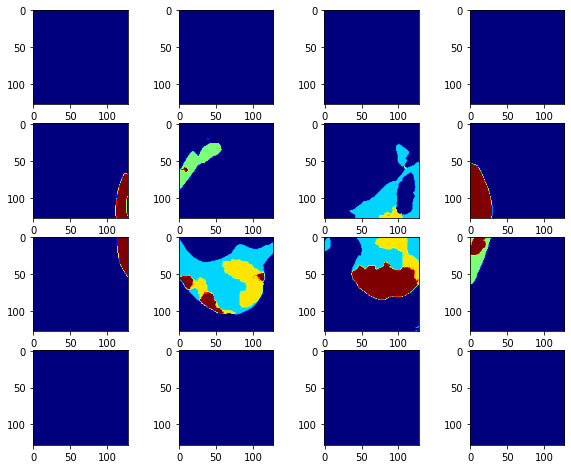

In [34]:
predicted_imm = []

for i in range(16) :
  test_img = imm_patch[i] 
  test_img=np.array(test_img)
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
 
  prediction = model.predict(test_img_input)
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  
  predicted_imm.append(predicted_img)

predicted_imm = np.array(predicted_imm)
figure = plt.figure(figsize=(10, 8))
cols, rows = 4,4
for i in range(1, cols * rows + 1):
  figure.add_subplot(rows, cols, i)
  plt.imshow(predicted_imm[i-1], cmap='jet')
print(predicted_imm.shape)

In [35]:
predicted_patches_reshaped = np.reshape(predicted_imm, (patches.shape[0], patches.shape[1], 128,128) )
print(predicted_patches_reshaped.shape)
reconstructed_image = unpatchify(predicted_patches_reshaped, maschera.shape)
print(reconstructed_image.shape)

(4, 4, 128, 128)
(512, 512)


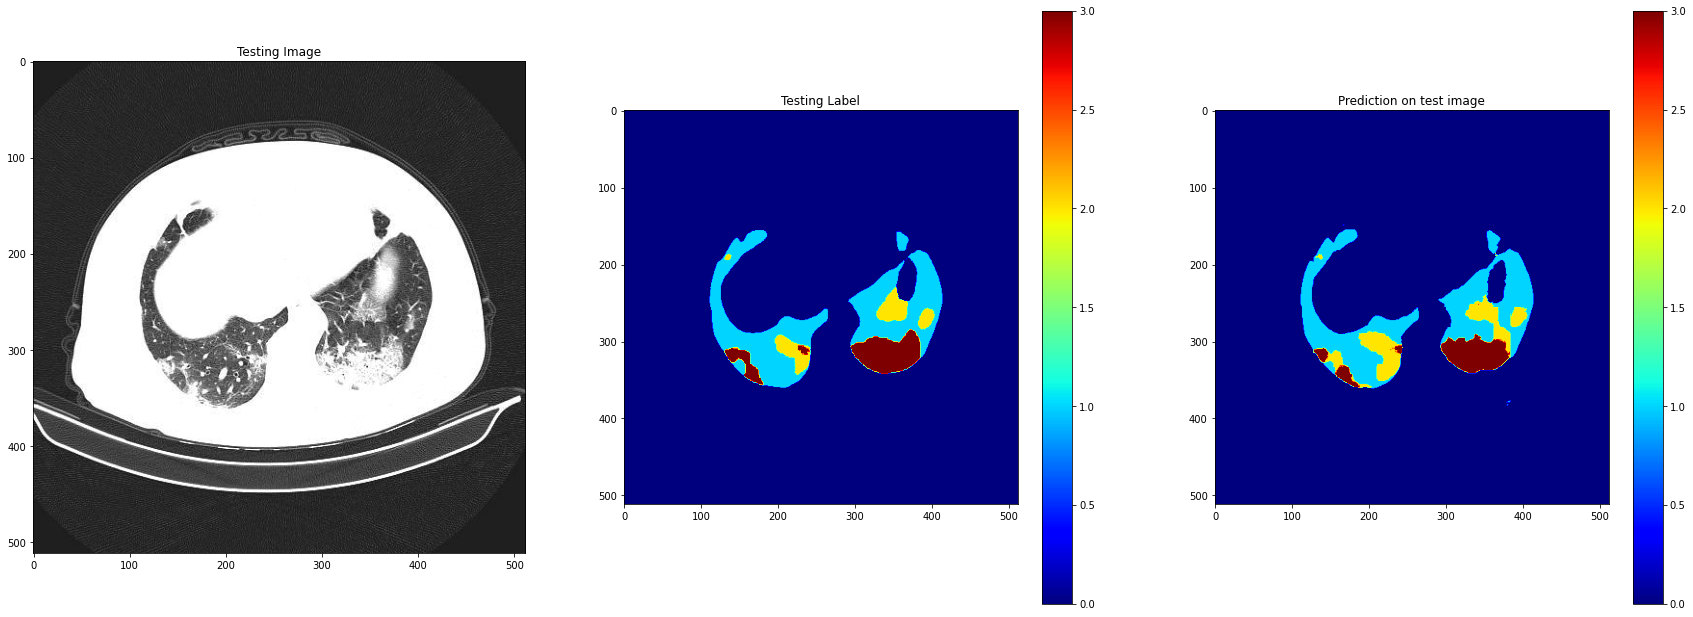

In [36]:
plt.figure(figsize=(30, 24))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(immagine[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(maschera[:,:], cmap='jet')
plt.colorbar()
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(reconstructed_image, cmap='jet')
plt.colorbar()
plt.show()

In [37]:
IOU_immagine = MeanIoU(num_classes=n_classes)
IOU_immagine.update_state(maschera, reconstructed_image)
print("Mean IoU =", IOU_immagine.result().numpy())


#Valutiamo la IoU per ogni classe sulla parte di immagini con tutte le label di test
values = np.array(IOU_immagine.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.76687837
[[2.37832e+05 4.24000e+02 1.80000e+01 7.90000e+01]
 [3.03000e+02 1.49110e+04 1.28600e+03 1.82000e+02]
 [7.20000e+01 3.50000e+02 2.24800e+03 3.60000e+01]
 [1.24000e+02 1.16000e+02 6.71000e+02 3.49200e+03]]
IoU for class1 is:  0.99572957
IoU for class2 is:  0.8485659
IoU for class3 is:  0.48023927
IoU for class4 is:  0.74297875
